In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
from pathlib import Path

import pandas
import matplotlib.pyplot as plt
import matplotlib as mpl
import altair as alt
import seaborn
seaborn.set_style("whitegrid")
seaborn.set_context("notebook")

mpl.rcParams['figure.dpi'] = 72
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['grid.color'] = '#dddddd'

In [3]:
# Load StrainGST data
BASE_PATH = Path("/gsap/archive-bacterial/Projects/umb_fixed/WMS/strainge")

straingst_data = []
sample_names = []
for fpath in BASE_PATH.glob("straingst/UMB11/*.tsv"):
    sample = fpath.stem
    
    if sample[-1].isalpha():
        continue
        
    df = pandas.read_csv(fpath, sep='\t', index_col=1, skiprows=2, comment='#')
    straingst_data.append(df)
    sample_names.append(sample)
    
straingst_df = pandas.concat(straingst_data, keys=sample_names, names=["sample"])

sample_names = list(sorted(sample_names, key=lambda e: float(e.replace("UMB11_", ""))))
straingst_df = straingst_df.loc[sample_names].copy()

In [4]:
straingst_df

i gkmers ikmers  \
sample     strain                                                            
UMB11_02   Esch_coli_NGF1                                  0  49631  49623   
UMB11_08   Esch_coli_1190                                  0  48261  48248   
UMB11_12   Esch_coli_1190                                  0  48261  48235   
           Esch_coli_26561                                 1  46249  19738   
UMB11_07   Esch_coli_1190                                  0  48261  48237   
           Esch_coli_f974b26a-5e81-11e8-bf7f-3c4a9275d6c8  1  47727  21265   
UMB11_11   Esch_coli_1190                                  0  48261  48248   
UMB11_05   Esch_coli_1190                                  0  48261  48248   
UMB11_04.1 Esch_coli_1190                                  0  48261  48250   
UMB11_03.1 Esch_coli_1190                                  0  48261  48254   
UMB11_06   Esch_coli_H3                                    0  45610  45560   
           Esch_coli_1190                                  1  48261  21600   
UMB11_01   Esch_coli_NGF1                                  0  49631  49622   
UMB11_03   Esch_coli_1190                                  0  48261  48249   

                                                          skmers    cov  \
sample     strain                                                         
UMB11_02   Esch_coli_NGF1                                   5358  0.103   
UMB11_08   Esch_coli_1190                                  31599  0.592   
UMB11_12   Esch_coli_1190                                  66509  0.941   
           Esch_coli_26561                                 21112  0.853   
UMB11_07   Esch_coli_1190                                  58276  0.854   
           Esch_coli_f974b26a-5e81-11e8-bf7f-3c4a9275d6c8  17074  0.441   
UMB11_11   Esch_coli_1190                                  49462  0.920   
UMB11_05   Esch_coli_1190                                  40411  0.775   
UMB11_04.1 Esch_coli_1190                                  19042  0.362   
UMB11_03.1 Esch_coli_1190                                  31201  0.595   
UMB11_06   Esch_coli_H3                                    74449  0.960   
           Esch_coli_1190                                  30714  0.794   
UMB11_01   Esch_coli_NGF1                                  50090  0.985   
UMB11_03   Esch_coli_1190                                  37144  0.711   

                                                              kcov     gcov  \
sample     strain                                                             
UMB11_02   Esch_coli_NGF1                                    1.546    0.158   
UMB11_08   Esch_coli_1190                                    2.243    1.309   
UMB11_12   Esch_coli_1190                                    9.061    8.431   
           Esch_coli_26561                                   4.773    3.983   
UMB11_07   Esch_coli_1190                                    4.557    3.846   
           Esch_coli_f974b26a-5e81-11e8-bf7f-3c4a9275d6c8    2.588    1.077   
UMB11_11   Esch_coli_1190                                    6.107    5.545   
UMB11_05   Esch_coli_1190                                    2.741    2.097   
UMB11_04.1 Esch_coli_1190                                    1.870    0.668   
UMB11_03.1 Esch_coli_1190                                    2.152    1.264   
UMB11_06   Esch_coli_H3                                    114.343  109.038   
           Esch_coli_1190                                    7.102    5.565   
UMB11_01   Esch_coli_NGF1                                    7.009    6.831   
UMB11_03   Esch_coli_1190                                    2.814    1.975   

                                                            acct   even  \
sample     strain                                                         
UMB11_02   Esch_coli_NGF1                                  0.932  0.707   
UMB11_08   Esch_coli_1190                                  0.904  0.810   
UMB11_12   Esch_coli_1190                   

In [5]:
# Load StrainGR data
straingr_data = []
for sample in sample_names:
    straingr_tsv = BASE_PATH / f"straingr/UMB11/{sample}.tsv"
    df = pandas.read_csv(straingr_tsv, sep='\t', index_col=[0, 1])
    df = df.drop(index='TOTAL', level=0)
    straingr_data.append(df)
    
straingr_df = pandas.concat(straingr_data, keys=sample_names)
straingr_df = straingr_df[straingr_df['length'] > 3e6]
straingr_df['enough_cov'] = straingr_df['coverage'] > 0.5
straingr_df['straingst_present'] = straingr_df.index.map(lambda ix: ix in straingst_df.index)

# Load StrainGR compare data
compare_data = []
COMPARE_SUMMARIES = BASE_PATH / "straingr/compare/UMB11"
for f in COMPARE_SUMMARIES.glob("*.summary.tsv"):
    df = pandas.read_csv(f, sep='\t', index_col=[0, 1, 2])
    compare_data.append(df)
compare_df = pandas.concat(compare_data)
compare_df = compare_df[~compare_df.index.duplicated(keep='first')].copy()

def enough_cov(ix):
    sample1, sample2, ref = ix
    
    if (sample1, ref) not in straingst_df.index or (sample2, ref) not in straingst_df.index:
        return False
    
    return straingr_df.loc[(sample1, ref), 'enough_cov'][0] and straingr_df.loc[(sample2, ref), 'enough_cov'][0]

compare_df['enough_cov'] = compare_df.index.map(enough_cov)
compare_pass_qc = compare_df[compare_df['enough_cov'] & (compare_df['commonPct'] > 0.5)]

/cil/shed/apps/internal/conda/envs/strainge/lib/python3.7/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


In [6]:
compare_pass_qc

scaffold   length   common  \
sample1    sample2  ref                                               
UMB11_03   UMB11_06 Esch_coli_1190  NZ_CP023386.1  4900891   327226   
UMB11_03.1 UMB11_08 Esch_coli_1190  NZ_CP023386.1  4900891    74590   
UMB11_05   UMB11_08 Esch_coli_1190  NZ_CP023386.1  4900891   143098   
           UMB11_06 Esch_coli_1190  NZ_CP023386.1  4900891   426954   
UMB11_03   UMB11_05 Esch_coli_1190  NZ_CP023386.1  4900891   244988   
UMB11_03.1 UMB11_12 Esch_coli_1190  NZ_CP023386.1  4900891   401255   
UMB11_06   UMB11_11 Esch_coli_1190  NZ_CP023386.1  4900891  1038547   
UMB11_03   UMB11_07 Esch_coli_1190  NZ_CP023386.1  4900891   396830   
UMB11_08   UMB11_11 Esch_coli_1190  NZ_CP023386.1  4900891   352245   
UMB11_05   UMB11_11 Esch_coli_1190  NZ_CP023386.1  4900891   778997   
UMB11_03   UMB11_08 Esch_coli_1190  NZ_CP023386.1  4900891   116616   
UMB11_06   UMB11_08 Esch_coli_1190  NZ_CP023386.1  4900891   194234   
           UMB11_12 Esch_coli_1190  NZ_CP023386.1  4900891  1101261   
UMB11_07   UMB11_12 Esch_coli_1190  NZ_CP023386.1  4900891  1371488   
UMB11_03   UMB11_12 Esch_coli_1190  NZ_CP023386.1  4900891   630879   
UMB11_03.1 UMB11_05 Esch_coli_1190  NZ_CP023386.1  4900891   158250   
           UMB11_07 Esch_coli_1190  NZ_CP023386.1  4900891   247771   
           UMB11_03 Esch_coli_1190  NZ_CP023386.1  4900891   125869   
UMB11_07   UMB11_08 Esch_coli_1190  NZ_CP023386.1  4900891   230318   
UMB11_06   UMB11_07 Esch_coli_1190  NZ_CP023386.1  4900891   698590   
UMB11_05   UMB11_12 Esch_coli_1190  NZ_CP023386.1  4900891   839914   
UMB11_11   UMB11_12 Esch_coli_1190  NZ_CP023386.1  4900891  2040509   
UMB11_07   UMB11_11 Esch_coli_1190  NZ_CP023386.1  4900891  1259716   
UMB11_05   UMB11_07 Esch_coli_1190  NZ_CP023386.1  4900891   531585   
UMB11_03.1 UMB11_11 Esch_coli_1190  NZ_CP023386.1  4900891   386681   
UMB11_08   UMB11_12 Esch_coli_1190  NZ_CP023386.1  4900891   373404   
UMB11_03.1 UMB11_06 Esch_coli_1190  NZ_CP023386.1  4900891   210546   
UMB11_03   UMB11_11 Esch_coli_1190  NZ_CP023386.1  4900891   601869   

                                    commonPct   single  singlePct  \
sample1    sample2  ref                                             
UMB11_03   UMB11_06 Esch_coli_1190     6.6769   327173    99.9838   
UMB11_03.1 UMB11_08 Esch_coli_1190     1.5220    74589    99.9987   
UMB11_05   UMB11_08 Esch_coli_1190     2.9198   143097    99.9993   
           UMB11_06 Esch_coli_1190     8.7118   426876    99.9817   
UMB11_03   UMB11_05 Esch_coli_1190     4.9988   244981    99.9971   
UMB11_03.1 UMB11_12 Esch_coli_1190     8.1874   401216    99.9903   
UMB11_06   UMB11_11 Esch_coli_1190    21.1910  1038379    99.9838   
UMB11_03   UMB11_07 Esch_coli_1190     8.0971   396805    99.9937   
UMB11_08   UMB11_11 Esch_coli_1190     7.1874   352225    99.9943   
UMB11_05   UMB11_11 Esch_coli_1190    15.8950   778952    99.9942   
UMB11_03   UMB11_08 Esch_coli_1190     2.3795   116615    99.9991   
UMB11_06   UMB11_08 Esch_coli_1190     3.9632   194197    99.9810   
           UMB11_12 Esch_coli_1190    22.4706  1101026    99.9787   
UMB11_07   UMB11_12 Esch_coli_1190    27.9845  1371263    99.9836   
UMB11_03   UMB11_12 Esch_coli_1190    12.8727   630820    99.9906   
UMB11_03.1 UMB11_05 Esch_coli_1190     3.2290   158244    99.9962   
           UMB11_07 Esch_coli_1190     5.0556   247748    99.9907   
           UMB11_03 Esch_coli_1190     2.5683   125869   100.0000   
UMB11_07   UMB11_08 Esch_coli_1190     4.6995   230287    99.9865   
UMB11_06   UMB11_07 Esch_coli_1190    14.2543   698448    99.9797   
UMB11_05   UMB11_12 Esch_coli_1190    17.1380   839821    99.9889   
UMB11_11   UMB11_12 Esch_coli_1190    41.6355  2040297    99.9896   
UMB11_07   UMB11_11 Esch_coli_1190    25.7038  1259586    99.9897   
UMB11_05   UMB11_07 Esch_coli_1190    10.8467   531521    99.9880   
UMB11_03.1 UMB11_11 Esch_coli_1190     7.8900   386672    99.9977   
UMB11_08   UMB11_12 Esch_coli_1190     7.6191  

In [7]:
c1 = alt.Chart(compare_pass_qc.reset_index()).mark_point().encode(
    alt.X('gapJaccardSim', scale=alt.Scale(zero=False, domain=[0.91, 1.0]), title="Gap Similarity"),
    alt.Y('singleAgreePct', scale=alt.Scale(zero=False, domain=[99.0, 100]), title="Pairwise ACNI", axis=alt.Axis(labelExpr='datum.label + "%"')),
    size=alt.Size('commonPct', type="quantitative", title="Common Callable [%]",
                  scale=alt.Scale(domain=(0, 30), range=(25, 300))),
    tooltip=['sample1', 'sample2', 'ref', 'commonPct', 'singleAgreePct', 'gapJaccardSim', 'sharedAllelesPct']
).properties(width=300, height=300)

display(c1)

c2 = alt.Chart(compare_pass_qc.reset_index()).mark_point().encode(
    alt.X('gapJaccardSim', scale=alt.Scale(zero=False, domain=[0.97, 1.0]), title="Gap Similarity"),
    alt.Y('singleAgreePct', scale=alt.Scale(zero=False, domain=[99.9, 100]), title="Pairwise ACNI", axis=alt.Axis(labelExpr='datum.label + "%"')),
    size=alt.Size('commonPct', type="quantitative", title="Common Callable [%]",
                  scale=alt.Scale(domain=(0, 30), range=(25, 300))),
    tooltip=['sample1', 'sample2', 'ref', 'commonPct', 'singleAgreePct', 'gapJaccardSim', 'sharedAllelesPct']
)

c2.properties(width=300, height=150)

alt.Chart(...)

alt.Chart(...)

## Load coverage and variant calls

In [8]:
import numpy
import pysam

from strainge.variant_caller import ALLELE_MASKS
from strainge.io.variants import call_data_from_hdf5

CONTIG_1190 = "NZ_CP023386.1"
LENGTH_1190 = 4900891
SUBSAMPLE = 10

coverages = {
    'sample': [],
    'pos': [],
    'cov': [],
}

callable_matrix = numpy.zeros((len(sample_names), LENGTH_1190), dtype=bool)
variant_matrix = numpy.zeros((len(sample_names), LENGTH_1190), dtype=numpy.uint8)
variant_matrix_weak = numpy.zeros((len(sample_names), LENGTH_1190), dtype=numpy.uint8)

pos = numpy.arange(LENGTH_1190)
pos_subsampled = pos[::SUBSAMPLE]

for row, sample in enumerate(sample_names):
    if (sample, "Esch_coli_1190") not in straingst_df.index:
        continue
        
    hdf5_path = BASE_PATH / f"straingr/UMB11/{sample}.hdf5"
    call_data = call_data_from_hdf5(hdf5_path)
    
    callable_smoothed = pandas.Series(call_data.scaffolds_data[CONTIG_1190].strong > 0).rolling(
        100, min_periods=1, center=True).sum() >= 2
    callable_matrix[row, :] = callable_smoothed
    
    variant_matrix[row, :] = call_data.scaffolds_data[CONTIG_1190].strong & ~call_data.scaffolds_data[CONTIG_1190].refmask
    variant_matrix[row, call_data.scaffolds_data[CONTIG_1190].lowmq] = 0
    
    variant_matrix_weak[row, :] = call_data.scaffolds_data[CONTIG_1190].weak & ~call_data.scaffolds_data[CONTIG_1190].refmask
    variant_matrix_weak[row, call_data.scaffolds_data[CONTIG_1190].lowmq] = 0
    
sample_ix = numpy.array([[sample] * len(pos_subsampled) for sample in sample_names])
callable_df = pandas.DataFrame({
    'sample': sample_ix.flatten(),
    'pos': numpy.tile(pos_subsampled, len(sample_names)),
    'callable': callable_matrix[:, ::SUBSAMPLE].flatten()
}).set_index('sample')

del callable_matrix


In [9]:
# Check which variants are observed in at least three samples
per_sample_alleles = (variant_matrix[:, :, numpy.newaxis] & ALLELE_MASKS[numpy.newaxis, numpy.newaxis, :4]).astype(bool)
per_sample_alleles_weak = (variant_matrix_weak[:, :, numpy.newaxis] & ALLELE_MASKS[numpy.newaxis, numpy.newaxis, :4]).astype(bool)

allele_counts_across_samples = per_sample_alleles.sum(axis=0)

In [10]:
from strainge.variant_caller import Allele

total_strong_across_samples = numpy.count_nonzero(allele_counts_across_samples > 0)
total_strong_2samples = numpy.count_nonzero(allele_counts_across_samples > 1)
total_strong_3samples = numpy.count_nonzero(allele_counts_across_samples > 2)

print("total strongly called across all samples:", total_strong_across_samples)
print("- at least two samples:", total_strong_2samples)
print("- at least three samples:", total_strong_3samples)

# Exclude weak alleles not strongly called in *any* sample
weak_alleles_exclude = allele_counts_across_samples < 1
per_sample_weak = per_sample_alleles_weak.copy()
per_sample_weak[:, weak_alleles_exclude] = 0

weak_counts_across_samples = per_sample_weak.sum(axis=0)

total_weak_2samples = numpy.count_nonzero(weak_counts_across_samples > 1)
total_weak_3samples = numpy.count_nonzero(weak_counts_across_samples > 2)
total_weak_5samples = numpy.count_nonzero(weak_counts_across_samples > 4)
total_weak_6samples = numpy.count_nonzero(weak_counts_across_samples > 5)

print("weakly called in")
print("- at least two samples:", total_weak_2samples)
print("- at least three samples:", total_weak_3samples)
print("- at least five samples:", total_weak_5samples)
print("- at least six samples:", total_weak_6samples)

pos_one_strong_and_five_weak = (allele_counts_across_samples.sum(axis=-1) > 0) & (weak_counts_across_samples.sum(axis=-1) > 4)
weak_alleles = variant_matrix[:, pos_one_strong_and_five_weak]

# Ensure that places without read data (weak == 0) don't affect bitwise AND
weak_alleles[weak_alleles == 0] |= 0xFFFF
print(weak_alleles.shape)

consistent_alleles = numpy.bitwise_and.reduce(weak_alleles, axis=0)
print(consistent_alleles.shape)
print(numpy.count_nonzero(consistent_alleles), "/", numpy.count_nonzero(pos_one_strong_and_five_weak))

pos = numpy.arange(LENGTH_1190)[pos_one_strong_and_five_weak]
for i in range(len(consistent_alleles)):
    var_pos = pos[i]
    print(var_pos, "; ".join(str(Allele(int(variant_matrix_weak[j, var_pos]))) for j in range(variant_matrix_weak.shape[0])), "-", str(Allele(int(consistent_alleles[i]))))


total strongly called across all samples: 3485
- at least two samples: 1249
- at least three samples: 703
weakly called in
- at least two samples: 2004
- at least three samples: 1642
- at least five samples: 837
- at least six samples: 442
(12, 839)
(839,)
836 / 839
14267 ; ; G; ; ; G; ; G; ; G; G; G - G
66066 ; ; T; T; ; ; T; T; T; ; T; T - T
85519 ; ; ; A; ; ; A; A; A; ; A; A - A
117539 ; ; A; A; ; A; ; A; A; ; A; A - A
141107 ; ; T; ; ; ; T; ; T; ; T; T - T
175839 ; ; G; G; ; ; ; G; G; G; G; G - G
205661 ; ; ; C; ; ; C; C; C; C; C; C - C
207282 ; ; A; ; ; ; A; A; A; ; A; A - A
210231 ; ; T; ; ; T; T; T; T; ; T; T - T
224360 ; ; A; ; ; ; A; ; A; ; A; A - A
248066 ; ; G; ; ; ; G; G; G; G; G; G - G
257499 ; ; A; ; ; A; A; A; ; A; A; A - A
261839 ; ; ; T; ; ; T; T; T; T; T; T - T
265336 ; ; G; ; ; G; G; G; ; G; G; G - G
268505 ; ; T; ; ; ; T; T; T; ; ; T - T
291211 ; ; ; G; ; ; G; ; ; G; G; G - G
296378 ; ; A; A; ; ; A; ; A; A; A; A - A
310602 ; ; G; G; ; ; G; G; ; G; G; G - G
347214 ; 

In [11]:
alleles_exclude = allele_counts_across_samples < 3
per_sample_alleles_pass = per_sample_alleles.copy()
per_sample_alleles_pass[:, alleles_exclude] = 0

per_sample_variants = per_sample_alleles_pass.sum(axis=-1) > 0
print(per_sample_variants.shape)

variant_density_data = {
    'sample': [],
    'pos': [],
    'density': []
}

for row, sample in enumerate(sample_names):
    density = pandas.Series(per_sample_variants[row], dtype=numpy.uint32).rolling(1000, min_periods=1, center=True).sum()
    variant_density_data['pos'].extend(pos_subsampled)
    variant_density_data['density'].extend(density[::SUBSAMPLE])
    variant_density_data['sample'].extend([sample] * len(pos_subsampled))
    

var_density_df = pandas.DataFrame(variant_density_data).set_index('sample')

(12, 4900891)


In [12]:
print(var_density_df['density'].min())
print(var_density_df['density'].max())
print()

print(var_density_df['pos'].min())
print(var_density_df['pos'].max())
print()

0.0
24.0

0
4900890



## Plot StrainGST results, callable, gaps and SNVs

In [13]:
from strainge.utils import find_consecutive_groups
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

def gen_patches_from_array(callable, pos, offset, height):
    patches = []
    
    for group, start, end, length in find_consecutive_groups(callable):
        if not numpy.all(group):
            continue
            
        # Round to nearest 100
        start = int(round(pos[start], -2))
        end = int(round(pos[end-1], -2))
        if start == end:
            end += 100
            
        width = end - start
        p = Rectangle((start, offset), width, height)
        patches.append(p)
        
    return patches


def gen_patches_from_bed(fname, offset, height, index=None):
    patches = []
    
    features = pandas.read_csv(fname, sep="\t", index_col=0, names=["chromosomes", "start", "end"])
    
    if index:
        features = features.loc[index]
    
    for start, end in features.itertuples(index=False):
        width = end - start
        p = Rectangle((start, offset), width, height)
        patches.append(p)
        
    return patches

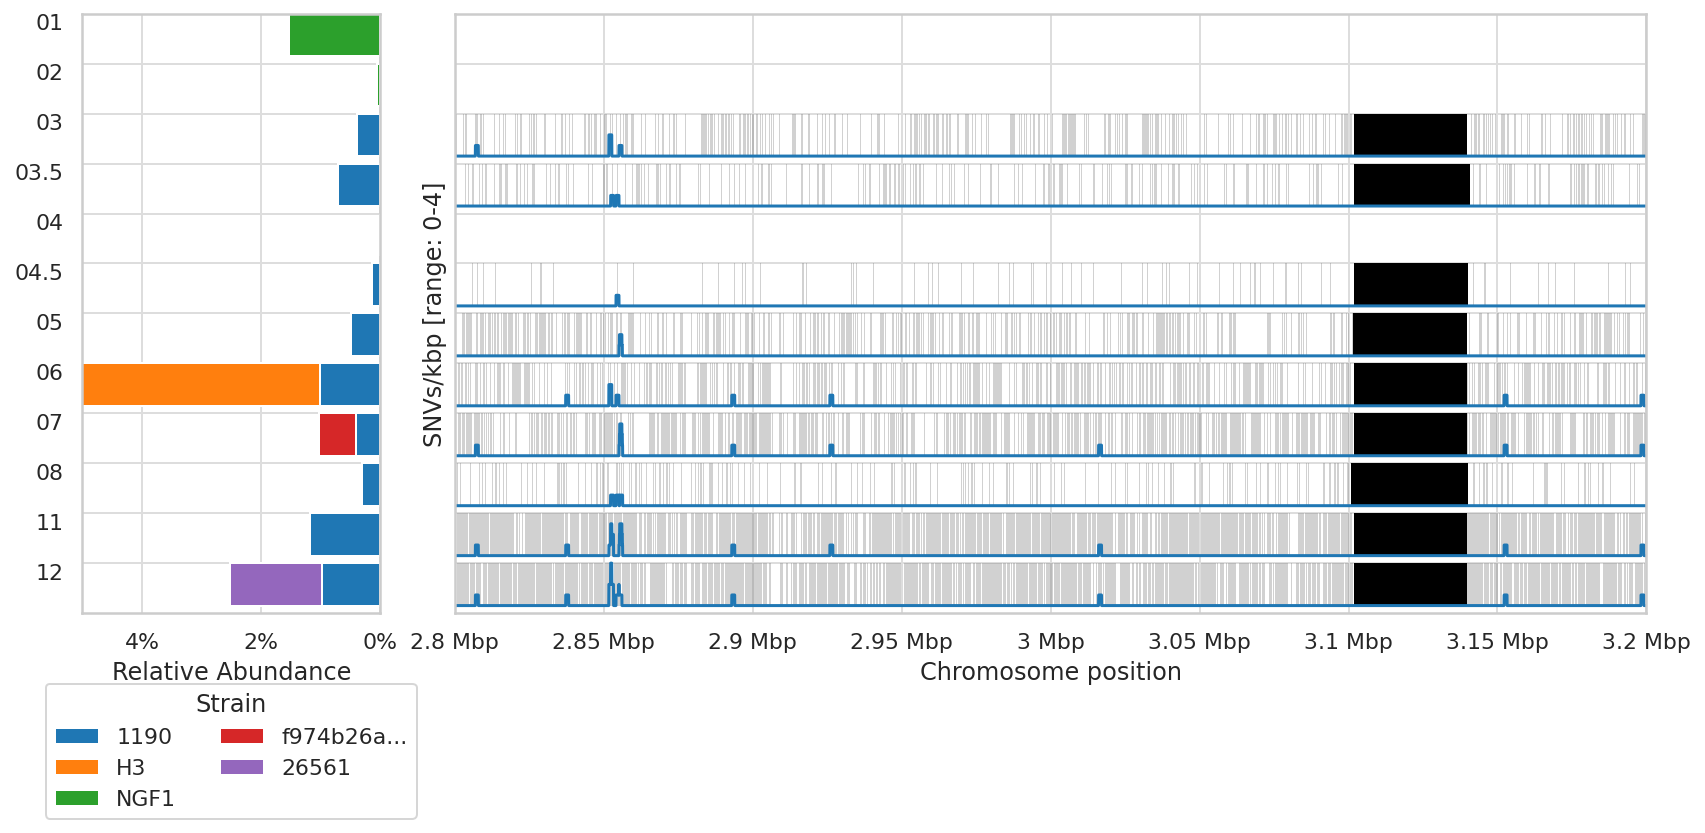

In [29]:
import seaborn
from sklearn.preprocessing import MinMaxScaler
from matplotlib.ticker import EngFormatter, StrMethodFormatter


BARHEIGHT = 0.85

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey='row', gridspec_kw={"width_ratios": [1.5, 6]})

strain_order = ['Esch_coli_1190', 'Esch_coli_H3', 'Esch_coli_NGF1', 'Esch_coli_f974b26a-5e81-11e8-bf7f-3c4a9275d6c8', "Esch_coli_26561"]
strain_labels = ['1190', 'H3', 'NGF1', 'f974b26a...', "26561"]
colors = seaborn.color_palette("tab10")
labels = [s.replace("UMB11_", "").replace(".1", ".5") for s in sample_names]

# Stacked barplot with StrainGST results
bottom = numpy.zeros(len(sample_names))
for ref, label, color in zip(strain_order, strain_labels, colors):
    ra = numpy.array([straingst_df.loc[(sample, ref), 'rapct'] if (sample, ref) in straingst_df.index else 0.0 for sample in sample_names])
    axes[0].barh(numpy.arange(len(sample_names)), ra, left=bottom, color=color, align='edge', tick_label=labels, label=label, height=BARHEIGHT)
    
    bottom += ra

axes[0].set_xlim(0, 5)
axes[0].set_ylim(0, len(sample_names))
axes[0].set_xlabel("Relative Abundance")
axes[0].xaxis.set_major_formatter(StrMethodFormatter("{x:g}%"))
axes[0].invert_xaxis()
axes[0].invert_yaxis()

axes[0].set_yticklabels(labels, va='top')
axes[0].legend(title="Strain", loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=2)

XMIN = 2.8e6
XMAX = 3.2e6
axes[1].set_xlim(XMIN, XMAX)

callable_in_range = callable_df[(callable_df['pos'] > XMIN) & (callable_df['pos'] <= XMAX)]

# Collect callable and gaps
callable_patches = []
gap_patches = []
for offset, sample in enumerate(sample_names):
    if (sample, "Esch_coli_1190") not in straingst_df.index:
        continue
        
    callable_patches.extend(gen_patches_from_array(callable_in_range.loc[sample, 'callable'].values, 
                                                   callable_in_range.loc[sample, 'pos'].values, 
                                                   offset, BARHEIGHT))
    #callable_patches.extend(gen_patches_from_bed(f"../umb/UMB11/straingr/{sample}.callable.bed", offset, BARHEIGHT, CONTIG_1190))
    gap_patches.extend(gen_patches_from_bed(BASE_PATH / f"straingr/UMB11/{sample}.gaps.bed", offset, BARHEIGHT, CONTIG_1190))
        
axes[1].add_collection(PatchCollection(callable_patches, facecolors="dimgrey", linewidths=0, alpha=0.3))
axes[1].add_collection(PatchCollection(gap_patches, facecolors="black", linewidths=0, alpha=1.0))

"""
MAX_COV = 15
cov_in_range = cov_df[(cov_df['pos'] > XMIN) & (cov_df['pos'] < XMAX)].copy()
min_max_scaler = MinMaxScaler(feature_range=(0, BARHEIGHT))
cov_in_range['cov_scaled'] = min_max_scaler.fit_transform(cov_in_range['cov'].clip(0, MAX_COV).values.reshape(-1, 1)).flatten()
        
# Plot coverage
for offset, sample in enumerate(sample_names):
    if (sample, "Esch_coli_1190") not in straingst_df.index:
        continue
        
    sample_cov = cov_in_range.loc[sample]
    cov_y = offset - sample_cov['cov_scaled'].values
    
    axes[1].fill_between(sample_cov['pos'].values, cov_y+BARHEIGHT, offset+BARHEIGHT, color="dimgrey", alpha=0.7, lw=0.0)
    #axes[1].plot(sample_cov['pos'].values, cov_y+BARHEIGHT, color="gray", alpha=0.8, lw=0.05)
        
axes[1].xaxis.set_major_formatter(EngFormatter(unit='bp')) 
axes[1].set_ylabel("Coverage (0x-15x)")
"""

snv_density_scaler = MinMaxScaler(feature_range=(0, BARHEIGHT))
var_density_in_range = var_density_df[(var_density_df['pos'] > XMIN) & (var_density_df['pos'] <= XMAX)].copy()
var_density_in_range.loc[:, 'density_scaled'] = snv_density_scaler.fit_transform(var_density_in_range['density'].values.reshape(-1, 1)).flatten()

density_min = var_density_in_range['density'].min()
density_max = var_density_in_range['density'].max()

# Plot SNV density
for offset, sample in enumerate(sample_names):
    if (sample, "Esch_coli_1190") not in straingst_df.index:
        continue
        
    sample_density = var_density_in_range.loc[sample]
    density_y = offset - sample_density['density_scaled'].values
    axes[1].plot(sample_density['pos'].values, density_y+BARHEIGHT, color=colors[0])

axes[1].xaxis.set_major_formatter(EngFormatter(unit='bp')) 
axes[1].set_xlabel("Chromosome position")
axes[1].set_ylabel(f"SNVs/kbp [range: {density_min:g}-{density_max:g}]")
fig.tight_layout()
fig.subplots_adjust(wspace=0.1)
fig.savefig('umb11.svg', bbox_inches='tight')

## UMB11 analysis with coarser databases

In [15]:
straingst_data = []
sample_names = []
for fpath in BASE_PATH.glob("straingst_db70/UMB11/*.tsv"):
    sample = fpath.stem
    
    if sample[-1].isalpha():
        continue
        
    df = pandas.read_csv(fpath, sep='\t', index_col=1, skiprows=2, comment='#')
    straingst_data.append(df)
    sample_names.append(sample)
    
straingst_db70 = pandas.concat(straingst_data, keys=sample_names, names=["sample"])

sample_names = list(sorted(sample_names, key=lambda e: float(e.replace("UMB11_", ""))))
straingst_db70 = straingst_db70.loc[sample_names].copy()


In [16]:
straingst_data = []
sample_names = []
for fpath in BASE_PATH.glob("straingst_db50/UMB11/*.tsv"):
    sample = fpath.stem
    
    if sample[-1].isalpha():
        continue
        
    df = pandas.read_csv(fpath, sep='\t', index_col=1, skiprows=2, comment='#')
    straingst_data.append(df)
    sample_names.append(sample)
    
straingst_db50 = pandas.concat(straingst_data, keys=sample_names, names=["sample"])

sample_names = list(sorted(sample_names, key=lambda e: float(e.replace("UMB11_", ""))))
straingst_db50 = straingst_db50.loc[sample_names].copy()

In [17]:
import json
from itertools import chain
from collections import defaultdict
from matplotlib.colors import rgb2hex

with open("clades.json") as f:
    clades = json.load(f)
    
clades["Esch_coli_str_TO60"] = "B2"
clades["Esch_coli_K-12_substr_GM4792_GCF_001020945.2"] = "A"
    
strains_per_clade = defaultdict(set)

for ref in chain(straingst_df.index.unique(level=1),
                 straingst_db70.index.unique(level=1),
                 straingst_db50.index.unique(level=1)):
    clade = clades[ref]
    strains_per_clade[clade].add(ref)
    
hues = seaborn.color_palette("colorblind")
del hues[3]
strain_color_map = {}
for clade, hue in zip(strains_per_clade.keys(), hues):
    clade_strains = list(sorted(strains_per_clade[clade]))
    for strain, color in zip(clade_strains, seaborn.light_palette(hue, n_colors=len(clade_strains)+3, reverse=True)):
        strain_color_map[strain] = rgb2hex(color)

strain_color_map

{'Esch_coli_NGF1': '#0173b2',
 'Esch_coli_str_TO60': '#3d93c2',
 'Esch_coli_1190': '#de8f05',
 'Esch_coli_AR_0006': '#e2a234',
 'Esch_coli_S10': '#e6b662',
 'Esch_coli_26561': '#029e73',
 'Esch_coli_K-12_substr_GM4792_GCF_001020945.2': '#30af8c',
 'Esch_coli_f974b26a-5e81-11e8-bf7f-3c4a9275d6c8': '#5fc0a4',
 'Esch_coli_H3': '#cc78bc',
 'Esch_coli_S40': '#d596c9'}

In [18]:
dense_strains = list(straingst_df.index.unique(level=1))
color_scale_dense = alt.Scale(domain=dense_strains, range=[strain_color_map[s] for s in dense_strains])

db70_strains = list(straingst_db70.index.unique(level=1))
color_scale_db70 = alt.Scale(domain=db70_strains, range=[strain_color_map[s] for s in db70_strains])

db50_strains = list(straingst_db50.index.unique(level=1))
color_scale_db50 = alt.Scale(domain=db50_strains, range=[strain_color_map[s] for s in db50_strains])

xscale = alt.Scale(domain=sample_names)
all_strains = list(chain.from_iterable(sorted(v) for v in strains_per_clade.values()))
all_strains_scale = alt.Scale(domain=all_strains, range=[strain_color_map[s] for s in all_strains])

width, height = 200, 150

orig_chart = alt.Chart(straingst_df.reset_index()).mark_bar().encode(
    x=alt.X('sample:N', scale=xscale, title="Sample", sort=sample_names),
    y=alt.Y('sum(rapct):Q', title="Relative abundance", axis=alt.Axis(labelExpr='datum.label + "%"'), scale=alt.Scale(domain=[0, 20])),
    color=alt.Color('strain:N', scale=all_strains_scale, title="Strain"),
    tooltip=['strain']
).properties(width=width, height=height)

db70_chart = alt.Chart(straingst_db70.reset_index()).mark_bar().encode(
    x=alt.X('sample:N', scale=xscale, title="Sample", sort=sample_names),
    y=alt.Y('sum(rapct):Q', title="Relative abundance", axis=alt.Axis(labelExpr='datum.label + "%"'), scale=alt.Scale(domain=[0, 20])),
    color=alt.Color('strain:N', scale=all_strains_scale, title="Strain"),
    tooltip=['strain']
).properties(width=width, height=height)

db50_chart = alt.Chart(straingst_db50.reset_index()).mark_bar().encode(
    x=alt.X('sample:N', scale=xscale, title="Sample", sort=sample_names),
    y=alt.Y('sum(rapct):Q', title="Relative abundance", axis=alt.Axis(labelExpr='datum.label + "%"'), scale=alt.Scale(domain=[0, 20])),
    color=alt.Color('strain:N', scale=all_strains_scale, title="Strain"),
    tooltip=['strain']
).properties(width=width, height=height)


(orig_chart & db70_chart & db50_chart).resolve_scale(y='shared', color='shared').properties(title="UMB11 with original and sparse E. coli DB")


alt.VConcatChart(...)

In [19]:
# Load StrainGR data
straingr_data = []
for sample in sample_names:
    straingr_tsv = BASE_PATH / f"straingr_db70/UMB11/{sample}.tsv"
    df = pandas.read_csv(straingr_tsv, sep='\t', index_col=[0, 1])
    df = df.drop(index='TOTAL', level=0)
    straingr_data.append(df)
    
straingr_db70 = pandas.concat(straingr_data, keys=sample_names)
straingr_db70 = straingr_db70[straingr_db70['length'] > 3e6]
straingr_db70['enough_cov'] = straingr_db70['coverage'] > 0.25

# Load StrainGR compare data
def enough_cov_gen(straingst_df, straingr_df):
    def enough_cov(ix):
        sample1, sample2, ref = ix

        if (sample1, ref) not in straingst_df.index or (sample2, ref) not in straingst_df.index:
            return False

        return straingr_df.loc[(sample1, ref), 'enough_cov'][0] and straingr_df.loc[(sample2, ref), 'enough_cov'][0]
    
    return enough_cov

compare_data = []
COMPARE_PATH_ALL = BASE_PATH / "straingr_db70/compare/UMB11"
for f in COMPARE_PATH_ALL.glob("*.vs.*.summary.tsv"):
    try:
        df = pandas.read_csv(f, sep='\t', index_col=[0, 1, 2])
        compare_data.append(df)
    except pandas.errors.EmptyDataError:
        pass
    
compare_db70 = pandas.concat(compare_data)
compare_db70['straingst_present'] = compare_db70.index.map(enough_cov_gen(straingst_db70, straingr_db70))

compare_db70_pass_qc = compare_db70[(compare_db70['commonPct'] > 0.5) & compare_db70['straingst_present']]
compare_db70_pass_qc

/cil/shed/apps/internal/conda/envs/strainge/lib/python3.7/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


scaffold   length   common  \
sample1    sample2    ref                                               
UMB11_03   UMB11_06   Esch_coli_1190  NZ_CP023386.1  4900891   311761   
UMB11_03.1 UMB11_08   Esch_coli_1190  NZ_CP023386.1  4900891    74608   
UMB11_05   UMB11_08   Esch_coli_1190  NZ_CP023386.1  4900891   143112   
           UMB11_06   Esch_coli_1190  NZ_CP023386.1  4900891   403312   
UMB11_03   UMB11_05   Esch_coli_1190  NZ_CP023386.1  4900891   244428   
UMB11_03.1 UMB11_12   Esch_coli_1190  NZ_CP023386.1  4900891   400587   
UMB11_06   UMB11_11   Esch_coli_1190  NZ_CP023386.1  4900891   989211   
UMB11_03   UMB11_07   Esch_coli_1190  NZ_CP023386.1  4900891   395381   
UMB11_08   UMB11_11   Esch_coli_1190  NZ_CP023386.1  4900891   350540   
UMB11_05   UMB11_11   Esch_coli_1190  NZ_CP023386.1  4900891   774457   
UMB11_03   UMB11_04.1 Esch_coli_1190  NZ_CP023386.1  4900891    37026   
           UMB11_08   Esch_coli_1190  NZ_CP023386.1  4900891   116327   
UMB11_06   UMB11_08   Esch_coli_1190  NZ_CP023386.1  4900891   183197   
           UMB11_12   Esch_coli_1190  NZ_CP023386.1  4900891  1050640   
UMB11_07   UMB11_12   Esch_coli_1190  NZ_CP023386.1  4900891  1368789   
UMB11_03   UMB11_12   Esch_coli_1190  NZ_CP023386.1  4900891   630277   
UMB11_04.1 UMB11_07   Esch_coli_1190  NZ_CP023386.1  4900891    77584   
           UMB11_06   Esch_coli_1190  NZ_CP023386.1  4900891    64857   
UMB11_03.1 UMB11_05   Esch_coli_1190  NZ_CP023386.1  4900891   158514   
UMB11_04.1 UMB11_12   Esch_coli_1190  NZ_CP023386.1  4900891   126163   
UMB11_03.1 UMB11_07   Esch_coli_1190  NZ_CP023386.1  4900891   247512   
           UMB11_03   Esch_coli_1190  NZ_CP023386.1  4900891   125455   
UMB11_07   UMB11_08   Esch_coli_1190  NZ_CP023386.1  4900891   229733   
UMB11_06   UMB11_07   Esch_coli_1190  NZ_CP023386.1  4900891   661914   
UMB11_05   UMB11_12   Esch_coli_1190  NZ_CP023386.1  4900891   839659   
UMB11_11   UMB11_12   Esch_coli_1190  NZ_CP023386.1  4900891  2034447   
UMB11_07   UMB11_11   Esch_coli_1190  NZ_CP023386.1  4900891  1252300   
UMB11_05   UMB11_07   Esch_coli_1190  NZ_CP023386.1  4900891   531250   
UMB11_03.1 UMB11_11   Esch_coli_1190  NZ_CP023386.1  4900891   384934   
UMB11_04.1 UMB11_05   Esch_coli_1190  NZ_CP023386.1  4900891    49453   
UMB11_03.1 UMB11_04.1 Esch_coli_1190  NZ_CP023386.1  4900891    27307   
UMB11_08   UMB11_12   Esch_coli_1190  NZ_CP023386.1  4900891   371722   
UMB11_03.1 UMB11_06   Esch_coli_1190  NZ_CP023386.1  4900891   200760   
UMB11_04.1 UMB11_11   Esch_coli_1190  NZ_CP023386.1  4900891   118572   
UMB11_03   UMB11_11   Esch_coli_1190  NZ_CP023386.1  4900891   600678   

                                      commonPct   single  singlePct  \
sample1    sample2    ref                                             
UMB11_03   UMB11_06   Esch_coli_1190     6.3613   311591    99.9455   
UMB11_03.1 UMB11_08   Esch_coli_1190     1.5223    74606    99.9973   
UMB11_05   UMB11_08   Esch_coli_1190     2.9201   143108    99.9972   
           UMB11_06   Esch_coli_1190     8.2294   403085    99.9437   
UMB11_03   UMB11_05   Esch_coli_1190     4.9874   244397    99.9873   
UMB11_03.1 UMB11_12   Esch_coli_1190     8.1738   400524    99.9843   
UMB11_06   UMB11_11   Esch_coli_1190    20.1843   988659    99.9442   
UMB11_03   UMB11_07   Esch_coli_1190     8.0675   395353    99.9929   
UMB11_08   UMB11_11   Esch_coli_1190     7.1526   350516    99.9932   
UMB11_05   UMB11_11   Esch_coli_1190    15.8024   774373    99.9892   
UMB11_03   UMB11_04.1 Esch_coli_1190     0.7555    37026   100.0000   
           UMB11_08   Esch_coli_1190     2.3736   116326    99.9991   
UMB11_06   UMB11_08   Esch_coli_1190     3.7380   183071    99.9312   
           UMB11_12   Esch_coli_1190    21.4377  1049963    99.9356   
UMB11_07   UMB11_12   Esch_coli_1190    27.9294  1368440    99.9745   
UMB11_03   UMB11_12   Esch_coli_1190    12.8605   630127    99.9762   
UMB11_04.1 UMB11_07   Esch_coli_1190     1.5831    77580    99.

In [20]:
# Load StrainGR data
straingr_data = []
for sample in sample_names:
    straingr_tsv = BASE_PATH / f"straingr_db50/UMB11/{sample}.tsv"
    df = pandas.read_csv(straingr_tsv, sep='\t', index_col=[0, 1])
    df = df.drop(index='TOTAL', level=0)
    straingr_data.append(df)
    
straingr_db50 = pandas.concat(straingr_data, keys=sample_names)
straingr_db50 = straingr_db50[straingr_db50['length'] > 3e6]
straingr_db50['enough_cov'] = straingr_db50['coverage'] > 0.25

# Load StrainGR compare data
compare_data = []
COMPARE_PATH_ALL = BASE_PATH / "straingr_db50/compare/UMB11"
for f in COMPARE_PATH_ALL.glob("*.vs.*.summary.tsv"):
    try:
        df = pandas.read_csv(f, sep='\t', index_col=[0, 1, 2])
        compare_data.append(df)
    except pandas.errors.EmptyDataError:
        pass
    
compare_db50 = pandas.concat(compare_data)
compare_db50['straingst_present'] = compare_db50.index.map(enough_cov_gen(straingst_db50, straingr_db50))

compare_db50_pass_qc = compare_db50[(compare_db50['commonPct'] > 0.5) & compare_db50['straingst_present']]
compare_db50_pass_qc

/cil/shed/apps/internal/conda/envs/strainge/lib/python3.7/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


scaffold  \
sample1    sample2  ref                                                           
UMB11_03   UMB11_06 Esch_coli_AR_0006                             NZ_CP024851.1   
UMB11_05   UMB11_08 Esch_coli_AR_0006                             NZ_CP024851.1   
           UMB11_06 Esch_coli_AR_0006                             NZ_CP024851.1   
UMB11_03   UMB11_05 Esch_coli_AR_0006                             NZ_CP024851.1   
                    Esch_coli_S10                                 NZ_CP031609.1   
UMB11_03.1 UMB11_12 Esch_coli_AR_0006                             NZ_CP024851.1   
UMB11_06   UMB11_11 Esch_coli_AR_0006                             NZ_CP024851.1   
UMB11_03   UMB11_07 Esch_coli_AR_0006                             NZ_CP024851.1   
UMB11_08   UMB11_11 Esch_coli_AR_0006                             NZ_CP024851.1   
                    Esch_coli_S10                                 NZ_CP031609.1   
UMB11_05   UMB11_11 Esch_coli_AR_0006                             NZ_CP024851.1   
                    Esch_coli_S10                                 NZ_CP031609.1   
UMB11_06   UMB11_08 Esch_coli_AR_0006                             NZ_CP024851.1   
           UMB11_12 Esch_coli_AR_0006                             NZ_CP024851.1   
                    Esch_coli_K-12_substr_GM4792_GCF_001020945.2  NZ_CP011342.2   
UMB11_07   UMB11_12 Esch_coli_AR_0006                             NZ_CP024851.1   
                    Esch_coli_K-12_substr_GM4792_GCF_001020945.2  NZ_CP011342.2   
UMB11_03   UMB11_12 Esch_coli_AR_0006                             NZ_CP024851.1   
UMB11_03.1 UMB11_05 Esch_coli_AR_0006                             NZ_CP024851.1   
           UMB11_07 Esch_coli_AR_0006                             NZ_CP024851.1   
           UMB11_03 Esch_coli_AR_0006                             NZ_CP024851.1   
UMB11_07   UMB11_08 Esch_coli_AR_0006                             NZ_CP024851.1   
UMB11_06   UMB11_07 Esch_coli_AR_0006                             NZ_CP024851.1   
                    Esch_coli_K-12_substr_GM4792_GCF_001020945.2  NZ_CP011342.2   
UMB11_05   UMB11_12 Esch_coli_AR_0006                             NZ_CP024851.1   
UMB11_11   UMB11_12 Esch_coli_AR_0006                             NZ_CP024851.1   
UMB11_07   UMB11_11 Esch_coli_AR_0006                             NZ_CP024851.1   
UMB11_05   UMB11_07 Esch_coli_AR_0006                             NZ_CP024851.1   
UMB11_03.1 UMB11_11 Esch_coli_AR_0006                             NZ_CP024851.1   
                    Esch_coli_S10                                 NZ_CP031609.1   
UMB11_08   UMB11_12 Esch_coli_AR_0006                             NZ_CP024851.1   
UMB11_03.1 UMB11_06 Esch_coli_AR_0006                             NZ_CP024851.1   
UMB11_03   UMB11_11 Esch_coli_AR_0006                             NZ_CP024851.1   
                    Esch_coli_S10                                 NZ_CP031609.1   

                                                                   length  \
sample1    sample2  ref                                                     
UMB11_03   UMB11_06 Esch_coli_AR_0006                             5054076   
UMB11_05   UMB11_08 Esch_coli_AR_0006                             5054076   
           UMB11_06 Esch_coli_AR_0006                             5054076   
UMB11_03   UMB11_05 Esch_coli_AR_0006                             5054076   
                    Esch_coli_S10                                 4821441   
UMB11_03.1 UMB11_12 Esch_coli_AR_0006                             5054076   
UMB11_06   UMB11_11 Esch_coli_AR_0006                             5054076   
UMB11_03   UMB11_07 Esch_coli_AR_0006                             5054076   
UMB11_08   UMB11_11 Esch_coli_AR_0006                             5054076   
                    Esch_coli_S10                                 4821441   
UMB11_05   UMB11_11 Esch_coli_AR_0006                             5054076   
                    Esch_coli_S10                                 4821441   
UMB1

In [21]:
c1 = alt.Chart(compare_pass_qc.reset_index()).mark_point(opacity=1.0).encode(
    alt.X('gapJaccardSim', scale=alt.Scale(zero=False, domain=[0.91, 1.0]), title="Gap Similarity"),
    alt.Y('singleAgreePct', scale=alt.Scale(zero=False, domain=[98.8, 100]), title="Pairwise ACNI", axis=alt.Axis(labelExpr='datum.label + "%"')),
    size=alt.Size('commonPct', type="quantitative", title="Common Callable [%]",
                  scale=alt.Scale(domain=(0, 30), range=(25, 150))),
    color=alt.Color('ref:N', scale=all_strains_scale),
    tooltip=['sample1', 'sample2', 'ref', 'commonPct', 'singleAgreePct', 'gapJaccardSim', 'sharedAllelesPct']
).properties(width=150, height=150)

c2 = alt.Chart(compare_db70_pass_qc.reset_index()).mark_point(opacity=1.0).encode(
    alt.X('gapJaccardSim', scale=alt.Scale(zero=False, domain=[0.91, 1.0]), title="Gap Similarity"),
    alt.Y('singleAgreePct', scale=alt.Scale(zero=False, domain=[98.8, 100]), title="Pairwise ACNI", axis=alt.Axis(labelExpr='datum.label + "%"')),
    size=alt.Size('commonPct', type="quantitative", title="Common Callable [%]",
                  scale=alt.Scale(domain=(0, 30), range=(25, 150))),
    color=alt.Color('ref:N', scale=all_strains_scale),
    tooltip=['sample1', 'sample2', 'ref', 'commonPct', 'singleAgreePct', 'gapJaccardSim', 'sharedAllelesPct']
).properties(width=150, height=150)

c3 = alt.Chart(compare_db50_pass_qc.reset_index()).mark_point(opacity=1.0).encode(
    alt.X('gapJaccardSim', scale=alt.Scale(zero=False, domain=[0.91, 1.0]), title="Gap Similarity"),
    alt.Y('singleAgreePct', scale=alt.Scale(zero=False, domain=[98.8, 100]), title="Pairwise ACNI", axis=alt.Axis(labelExpr='datum.label + "%"')),
    size=alt.Size('commonPct', type="quantitative", title="Common Callable [%]",
                  scale=alt.Scale(domain=(0, 30), range=(25, 150))),
    color=alt.Color('ref:N', scale=all_strains_scale),
    tooltip=['sample1', 'sample2', 'ref', 'commonPct', 'singleAgreePct', 'gapJaccardSim', 'sharedAllelesPct']
).properties(width=150, height=150)

(c1 & c2 & c3).resolve_scale(color='shared')

alt.VConcatChart(...)

In [22]:
straingst_charts = [orig_chart, db70_chart, db50_chart]
straingr_charts = [c1, c2, c3]

final_chart = None
for col1, col2 in zip(straingst_charts, straingr_charts):
    row = (col1 | col2).resolve_scale(color='shared')
    if final_chart is None:
        final_chart = row
    else:
        final_chart &= row
        
final_chart

alt.VConcatChart(...)

## How the references are distributed across the tree

In [23]:
import numpy
from ete3 import Tree

tree = Tree('/gsap/archive-bacterial/Projects/StrainGE/strainge-benchmarks/cobra/ecoli.scc.nwk')
leaves = [l.name for l in tree]
to_keep = set(leaves)
to_keep.update(db70_strains)
to_keep.update(db50_strains)


def similarities_to_matrix(similarities, labels, metric='jaccard'):
    """Turn the pairwise similarities into a symmetric matrix."""

    label_ix = {label: i for i, label in enumerate(labels)}

    matrix = numpy.empty((len(labels), len(labels)))
    for kmerset1, kmerset2 in similarities.index:
        if kmerset1 not in label_ix:
            continue
            
        if kmerset2 not in label_ix:
            continue
            
        i = label_ix[kmerset1]
        j = label_ix[kmerset2]

        if metric == 'subset':
            matrix[i, j] = similarities.loc[(kmerset1, kmerset2), 'subset1']
            matrix[j, i] = similarities.loc[(kmerset1, kmerset2), 'subset2']
        else:
            matrix[i, j] = similarities.loc[(kmerset1, kmerset2), metric]
            matrix[j, i] = similarities.loc[(kmerset1, kmerset2), metric]

    for i in range(len(label_ix)):
        matrix[i, i] = numpy.nan

    return pandas.DataFrame(matrix, index=labels, columns=labels)


to_keep = list(to_keep)
similarities = pandas.read_csv('/gsap/garage-bacterial/Projects/StrainGE/straingst-benchmarks/db/similarities.tsv', sep='\t', index_col=[0, 1])
sim_matrix = similarities_to_matrix(similarities, to_keep)

sim_matrix

,Esch_coli_RM14723,Esch_coli_Y5,Esch_coli_ABU_83972,Esch_coli_K71-77,Esch_coli_AR436,Esch_coli_2014C-3097,Esch_coli_AMSCJX02,Esch_coli_2012C-4606,Esch_coli_L73,Esch_coli_Ecol_AZ155,...,Esch_coli_NCTC9966,Esch_coli_SCEC020022,Esch_coli_ACN001,Esch_coli_RM12581,Esch_coli_2016C-3878,Esch_coli_LS4,Esch_coli_AR_0081,Esch_coli_210205630,Esch_coli_ATCC_8739_GCF_000019385.1,Esch_coli_MVAST0167
Esch_coli_RM14723,NaN,0.32898,0.55815,0.32506,0.33462,0.32946,0.34250,0.32565,0.32697,0.33410,...,0.32840,0.33211,0.32765,0.33601,0.38263,0.52670,0.52503,0.33005,0.33619,0.53140
Esch_coli_Y5,0.32898,NaN,0.32856,0.55512,0.56636,0.52831,0.54779,0.51148,0.70305,0.74472,...,0.65357,0.55116,0.55582,0.43445,0.37199,0.32561,0.33906,0.53546,0.63690,0.34303
Esch_coli_ABU_83972,0.55815,0.32856,NaN,0.33063,0.32712,0.31823,0.33165,0.31380,0.31702,0.32539,...,0.31435,0.32026,0.32308,0.30970,0.37634,0.56649,0.56284,0.31408,0.32240,0.57074
Esch_coli_K71-77,0.32506,0.55512,0.33063,NaN,0.62575,0.60676,0.61303,0.58335,0.54785,0.56877,...,0.54549,0.61807,0.81978,0.42517,0.36805,0.31948,0.33188,0.61152,0.57721,0.33851
Esch_coli_AR436,0.33462,0.56636,0.32712,0.62575,NaN,0.66137,0.68024,0.62714,0.54109,0.58929,...,0.53286,0.88394,0.63766,0.43161,0.37268,0.32553,0.33781,0.69557,0.55369,0.34131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Esch_coli_LS4,0.52670,0.32561,0.56649,0.31948,0.32553,0.31842,0.32766,0.31856,0.31864,0.32483,...,0.31677,0.31938,0.32303,0.31314,0.36325,NaN,0.88587,0.31868,0.32123,0.78763
Esch_coli_AR_0081,0.52503,0.33906,0.56284,0.33188,0.33781,0.32551,0.33597,0.32551,0.32645,0.34116,...,0.32646,0.32946,0.33455,0.31984,0.37217,0.88587,NaN,0.32591,0.32975,0.81116
Esch_coli_210205630,0.33005,0.53546,0.31408,0.61152,0.69557,0.66430,0.66061,0.61816,0.53924,0.57642,...,0.53882,0.68845,0.62187,0.42777,0.36951,0.31868,0.32591,NaN,0.55310,0.32863
Esch_coli_ATCC_8739_GCF_000019385.1,0.33619,0.63690,0.32240,0.57721,0.55369,0.55017,0.55550,0.52181,0.64574,0.62363,...,0.64086,0.55537,0.57550,0.44600,0.37558,0.32123,0.32975,0.55310,NaN,0.33336


In [24]:
ix = sim_matrix['Esch_coli_str_TO60'].argmax()
print(sim_matrix.index[ix])

ix = sim_matrix['Esch_coli_K-12_substr_GM4792_GCF_001020945.2'].argmax()
print(sim_matrix.index[ix])

Esch_coli_JJ1886
Esch_coli_J53


In [25]:
print(sim_matrix.loc['Esch_coli_J53', 'Esch_coli_H3'])

print(sim_matrix.loc['Esch_coli_S10', 'Esch_coli_AR_0006'])

0.56357
0.46729


In [26]:
with open('/gsap/garage-bacterial/Projects/StrainGE/straingst-benchmarks/db/k50.txt') as f:
    sparse_db_refs = [Path(l).stem for l in f]
    
leaves_set = set(leaves)

with open('../sparse_db_itol_db50.txt', 'w') as o:
    print("DATASET_BINARY", file=o)
    print("SEPARATOR COMMA", file=o)
    print("DATASET_LABEL,Sparse DB", file=o)
    print("COLOR,#000000", file=o)
    print("FIELD_SHAPES,2", file=o)
    print("FIELD_LABELS,Present", file=o)
    
    print("DATA", file=o)
    for ref in sparse_db_refs:
        if ref not in sim_matrix:
            print("Skipping", ref)
            continue
            
        if ref not in leaves_set:
            closest_in_tree = sim_matrix[ref].idxmax()
        else:
            closest_in_tree = ref
        
        print(ref, closest_in_tree, closest_in_tree in leaves_set)
        print(closest_in_tree, "1", sep=',', file=o)
        

Esch_coli_K-12_substr_GM4792_GCF_001020945.2 Esch_coli_J53 True
Esch_coli_str_TO60 Esch_coli_JJ1886 True
Esch_coli_AR_0006 Esch_coli_AR_0006 True
Esch_coli_MS6198 Esch_coli_MS6198 True
Skipping Esch_albertii_EC06-170
Esch_coli_MSHS_133 Esch_coli_MSHS_133 True
Shig_dysenteriae_80-547 Shig_dysenteriae_80-547 True
Skipping Esch_coli_NCTC11133
Shig_boydii_ATCC_49812 Shig_boydii_ATCC_49812 True
Skipping Esch_fergusonii_EFCF056
Esch_coli_06-00048 Esch_coli_06-00048 True
Esch_coli_2013C-4282 Esch_coli_2013C-4282 True
Skipping Esch_coli_EC-12536
Skipping Esch_coli_NCTC11104
Esch_coli_S10 Esch_coli_S10 True
Skipping Esch_sp._E4742
Shig_dysenteriae_ATCC_12039 Shig_dysenteriae_ATCC_12039 True


In [27]:
with open('/gsap/garage-bacterial/Projects/StrainGE/straingst-benchmarks/db/k70.txt') as f:
    sparse_db_refs = [Path(l).stem for l in f]
    
with open('../sparse_db_itol_db70.txt', 'w') as o:
    print("DATASET_BINARY", file=o)
    print("SEPARATOR COMMA", file=o)
    print("DATASET_LABEL,Sparse DB", file=o)
    print("COLOR,#000000", file=o)
    print("FIELD_SHAPES,2", file=o)
    print("FIELD_LABELS,Present", file=o)
    
    print("DATA", file=o)
    for ref in sparse_db_refs:
        if ref not in sim_matrix:
            print("Skipping", ref)
            continue
            
        if ref not in leaves_set:
            closest_in_tree = sim_matrix[ref].idxmax()
        else:
            closest_in_tree = ref
        
        print(ref, closest_in_tree, closest_in_tree in leaves_set)
        print(closest_in_tree, "1", sep=',', file=o)
        

Esch_coli_K-12_substr_GM4792_GCF_001020945.2 Esch_coli_J53 True
Esch_coli_S40 Esch_coli_S40 True
Skipping Esch_coli_ECP17-1298
Esch_coli_str_TO60 Esch_coli_JJ1886 True
Skipping Esch_coli_CFSAN027346
Skipping Shig_flexneri_981
Esch_coli_EC-TO75 Esch_coli_EC-TO75 True
Esch_coli_UM146 Esch_coli_UM146 True
Skipping Esch_coli_FDAARGOS_403
Shig_dysenteriae_ATCC_49347 Shig_dysenteriae_ATCC_49347 True
Esch_coli_7_2 Esch_coli_7_2 True
Skipping Esch_coli_FDAARGOS_497
Esch_coli_2013C-4830 Esch_coli_2013C-4830 True
Skipping Esch_coli_clone_D_i2
Esch_coli_Ecol_545 Esch_coli_Ecol_545 True
Esch_coli_MSHS_133 Esch_coli_MSHS_133 True
Esch_coli_BH100_substr_MG2017 Esch_coli_BH100_substr_MG2017 True
Esch_coli_RM9872 Esch_coli_RM9872 True
Skipping Esch_coli_2014C-3599
Shig_dysenteriae_80-547 Shig_dysenteriae_80-547 True
Skipping Esch_albertii_06-3542
Esch_coli_F8111-1SC3 Esch_coli_F8111-1SC3 True
Esch_coli_MRY15-117 Esch_coli_MRY15-117 True
Esch_coli_RM14723 Esch_coli_RM14723 True
Skipping Shig_sonnei_FDA

In [28]:
with open('/gsap/garage-bacterial/Projects/StrainGE/straingst-benchmarks/db/keep90.txt') as f:
    db_refs = [Path(l).stem for l in f]
    
with open('../itol_db90.txt', 'w') as o:
    print("DATASET_BINARY", file=o)
    print("SEPARATOR COMMA", file=o)
    print("DATASET_LABEL,Sparse DB", file=o)
    print("COLOR,#000000", file=o)
    print("FIELD_SHAPES,2", file=o)
    print("FIELD_LABELS,Present", file=o)
    
    print("DATA", file=o)
    for ref in db_refs:
        if ref not in sim_matrix:
            print("Skipping", ref)
            continue
            
        if ref not in leaves_set:
            closest_in_tree = sim_matrix[ref].idxmax()
        else:
            closest_in_tree = ref
        
        print(ref, closest_in_tree, closest_in_tree in leaves_set)
        print(closest_in_tree, "1", sep=',', file=o)
        

Esch_coli_149 Esch_coli_149 True
Esch_coli_JJ1886 Esch_coli_JJ1886 True
Esch_coli_EC-TO75 Esch_coli_EC-TO75 True
Esch_coli_WCHEC005237 Esch_coli_WCHEC005237 True
Shig_flexneri_ATCC_29903 Shig_flexneri_ATCC_29903 True
Esch_coli_CFSAN027343 Esch_coli_CFSAN027343 True
Esch_coli_2013C-4361 Esch_coli_2013C-4361 True
Esch_coli_AR_0006 Esch_coli_AR_0006 True
Esch_coli_clone_D_i14 Esch_coli_clone_D_i14 True
Esch_coli_MVAST0167 Esch_coli_MVAST0167 True
Esch_coli_UM146 Esch_coli_UM146 True
Esch_coli_ATCC_11775 Esch_coli_ATCC_11775 True
Esch_coli_MRY15-117 Esch_coli_MRY15-117 True
Esch_coli_2013C-4830 Esch_coli_2013C-4830 True
Shig_sp._PAMC_28760 Shig_sp._PAMC_28760 True
Esch_coli_BH100_substr_MG2017 Esch_coli_BH100_substr_MG2017 True
Esch_coli_ECONIH1 Esch_coli_ECONIH1 True
Esch_coli_RM9872 Esch_coli_RM9872 True
Esch_coli_FMU073332 Esch_coli_FMU073332 True
Esch_coli_SA186 Esch_coli_SA186 True
Esch_coli_SCEC020023 Esch_coli_SCEC020023 True
Esch_coli_F5505-C1 Esch_coli_F5505-C1 True
Esch_coli_KO11